In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [4]:
import sys 
sys.path.append("../../")

In [5]:
from proj_mod import drop_extreme

In [6]:
from proj_mod import data_shifting

In [7]:
all_data=pd.read_csv("../../data/processed/all_data_collection.csv")

In [8]:
all_data.columns

Index(['Date', 'tech_index_daily_pro_change', 'cop_daily_pro_change',
       'gold_daily_pro_change', 'silv_daily_pro_change',
       'pal_daily_pro_change', 'plat_daily_pro_change',
       'crude_oil_daily_pro_change', 'fed_dff_daily',
       'ppi314_monthly_pro_change', 'ppi332_monthly_pro_change',
       'ppi333_monthly_pro_change', 'ppi334_monthly_pro_change',
       'ppi335_monthly_pro_change', 'ppi336_monthly_pro_change',
       'ppi339_monthly_pro_change', 'ppi516_monthly_pro_change',
       'ppi517_monthly_pro_change', 'ppi5132_monthly_pro_change',
       'ppi5182_monthly_pro_change'],
      dtype='object')

In [9]:
all_data_extended = all_data.copy(deep=True)

In [10]:
lst_cols_shift=['tech_index_daily_pro_change', 'cop_daily_pro_change',
       'gold_daily_pro_change', 'silv_daily_pro_change',
       'pal_daily_pro_change', 'plat_daily_pro_change',
       'crude_oil_daily_pro_change']

In [11]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression

In [12]:
arr_mse_kfold_collection=[] #Each row is for one int_extend. Then for each row index zero is for the training with extreme values, and index one is for the training without extreme values. 
arr_mse_kfold_de_collection=[] #Each row is for one int_extend. Then for each row index zero is for the training with extreme values, and index one is for the training without extreme values. 
for int_extend in range(11): 
    if int_extend != 0: 
        for col in lst_cols_shift: 
            all_data_extended=data_shifting.shifter(df_in=all_data_extended,str_col=col,int_shift=int_extend)
    all_data_extended_train=all_data_extended[all_data_extended["Date"]<"2024-01-01"].dropna()
    # all_data_extended_de=drop_extreme.drop_by_sort(df_in=all_data_extended.dropna(),fl_low=0.001,fl_high=0.999)
    # all_data_extended_train_de=drop_extreme.drop_by_sort(df_in=all_data_extended_train,fl_low=0.001,fl_high=0.999)
    # all_data_extended_test=all_data_extended[all_data_extended["Date"]>="2024-01-01"].dropna()
    X_train=all_data_extended_train.iloc[:,2:]
    y_train=all_data_extended_train.iloc[:,1]
    # X_de_train=all_data_extended_train_de.iloc[:,2:]
    # y_de_train=all_data_extended_train_de.iloc[:,1]
    # X_test=all_data_extended_test.iloc[:,2:]
    # y_test=all_data_extended_test.iloc[:,1]
    spineline_pipe = Pipeline([
    ("std", StandardScaler()),               # 1) Standardize features
    ("spline", SplineTransformer(n_knots=2, degree=1)),
    ("regressor", LinearRegression())        # 2) Fit a regression model
])
    time_kfold=TimeSeriesSplit(n_splits=5)
    fold_mse=[]
    fold_mse_de=[]
    #First for without deleting extreme values. 
    for index_train, index_test in time_kfold.split(X_train): 
        X_tt=X_train.iloc[index_train]
        y_tt=y_train.iloc[index_train]
        X_ho=X_train.iloc[index_test]
        y_ho=y_train.iloc[index_test]
        all_data_ho_de=drop_extreme.drop_by_sort(df_in=all_data_extended_train.iloc[index_test], fl_low=0.01, fl_high=0.99)
        X_ho_de=all_data_ho_de.iloc[:,2:]
        y_ho_de=all_data_ho_de.iloc[:,1]
        spineline_pipe.fit(X=X_tt,y=y_tt)
        pred=spineline_pipe.predict(X=X_ho)
        error=mean_squared_error(y_pred=pred,y_true=y_ho)
        fold_mse.append(error)
        pred_de=spineline_pipe.predict(X=X_ho_de)
        error_de=mean_squared_error(y_pred=pred_de,y_true=y_ho_de)
        fold_mse_de.append(error_de)
    mean_error=np.mean(fold_mse)
    arr_mse_kfold_collection.append([])
    arr_mse_kfold_collection[-1].append(mean_error)
    mean_error_de=np.mean(fold_mse_de)
    arr_mse_kfold_de_collection.append([])
    arr_mse_kfold_de_collection[-1].append(mean_error_de)
    print("mse trained on "+str(int_extend)+" index shifting and WITHOUT deleting extreme values is "+str(mean_error)+" with k fold.")
    fold_mse=[]
    fold_mse_de=[]
    #Then the one with deleting extreme values. 
    for index_train, index_test in time_kfold.split(X_train): 
        all_data_tt=drop_extreme.drop_by_sort(df_in=all_data_extended_train.iloc[index_train], fl_low=0.001, fl_high=0.999)  #all_data_extended_train.iloc[index_train]
        all_data_ho=drop_extreme.drop_by_sort(df_in=all_data_extended_train.iloc[index_test], fl_low=0.01, fl_high=0.99) #all_data_extended_train.iloc[index_test]
        X_tt=all_data_tt.iloc[:,2:] #drop_extreme.drop_by_sort(df_in=X_train.iloc[index_train], fl_low=0.01, fl_high=0.99)     #X_de_train.iloc[index_train]
        y_tt=all_data_tt.iloc[:,1] #drop_extreme.drop_by_sort(df_in=y_train.iloc[index_train], fl_low=0.01, fl_high=0.99) 
        X_ho_de=all_data_ho.iloc[:,2:] #drop_extreme.drop_by_sort(df_in=X_train.iloc[index_test], fl_low=0.01, fl_high=0.99) #X_train.iloc[index_test]
        y_ho_de=all_data_ho.iloc[:,1] #drop_extreme.drop_by_sort(df_in=y_train.iloc[index_test], fl_low=0.01, fl_high=0.99) #y_train.iloc[index_test]
        X_ho=X_train.iloc[index_test]
        y_ho=y_train.iloc[index_test]
        spineline_pipe.fit(X=X_tt,y=y_tt)
        pred=spineline_pipe.predict(X=X_ho)
        error=mean_squared_error(y_pred=pred,y_true=y_ho)
        fold_mse.append(error)
        pred_de=spineline_pipe.predict(X=X_ho_de)
        error_de=mean_squared_error(y_pred=pred_de,y_true=y_ho_de)
        fold_mse_de.append(error_de)
    mean_error=np.mean(fold_mse)
    arr_mse_kfold_collection[-1].append(mean_error)
    mean_error_de=np.mean(fold_mse_de)
    arr_mse_kfold_de_collection[-1].append(mean_error_de)
    print("mse trained on "+str(int_extend)+" index shifting and WITH deleting extreme values is "+str(mean_error)+" with k fold.")
    print("\n"+"Finished training and testing for "+str(int_extend)+" shiftings.")
        

mse trained on 0 index shifting and WITHOUT deleting extreme values is 2.0320833473198574 with k fold.
mse trained on 0 index shifting and WITH deleting extreme values is 2.0413974367219887 with k fold.

Finished training and testing for 0 shiftings.
mse trained on 1 index shifting and WITHOUT deleting extreme values is 2.0394742632451512 with k fold.
mse trained on 1 index shifting and WITH deleting extreme values is 2.0414927702633 with k fold.

Finished training and testing for 1 shiftings.
mse trained on 2 index shifting and WITHOUT deleting extreme values is 2.0754964011687234 with k fold.
mse trained on 2 index shifting and WITH deleting extreme values is 2.0734832333290827 with k fold.

Finished training and testing for 2 shiftings.
mse trained on 3 index shifting and WITHOUT deleting extreme values is 2.1304109924820933 with k fold.
mse trained on 3 index shifting and WITH deleting extreme values is 2.101489852337087 with k fold.

Finished training and testing for 3 shiftings.


In [13]:
arr_mse_kfold_collection

[[np.float64(2.0320833473198574), np.float64(2.0413974367219887)],
 [np.float64(2.0394742632451512), np.float64(2.0414927702633)],
 [np.float64(2.0754964011687234), np.float64(2.0734832333290827)],
 [np.float64(2.1304109924820933), np.float64(2.101489852337087)],
 [np.float64(2.139562770300936), np.float64(2.1238949535543967)],
 [np.float64(2.1885964032163936), np.float64(2.1551061211107787)],
 [np.float64(2.202616416407911), np.float64(2.1720569092427087)],
 [np.float64(2.204101469649566), np.float64(2.1834644842747233)],
 [np.float64(2.193644261733165), np.float64(2.180906457214772)],
 [np.float64(2.2229229889082998), np.float64(2.230144333530885)],
 [np.float64(2.24220067213837), np.float64(2.2726104587391105)]]

In [14]:
arr_mse_kfold_de_collection

[[np.float64(1.5218322206045258), np.float64(1.5216090898845747)],
 [np.float64(1.3006202346744056), np.float64(1.295602074562553)],
 [np.float64(1.291008777772729), np.float64(1.272154727254448)],
 [np.float64(1.2939375725825304), np.float64(1.2647633097607902)],
 [np.float64(1.2626125234274097), np.float64(1.2382820960103254)],
 [np.float64(1.2408119504629869), np.float64(1.2069892220984404)],
 [np.float64(1.2600337921562577), np.float64(1.22826477880683)],
 [np.float64(1.2126968518722268), np.float64(1.1827670909569223)],
 [np.float64(1.2186150281213137), np.float64(1.183379893831852)],
 [np.float64(1.242711311606021), np.float64(1.2205788728664921)],
 [np.float64(1.19507286271852), np.float64(1.178142549479334)]]

In [15]:
arr_in=np.array(arr_mse_kfold_de_collection).transpose()

In [16]:
np.array(arr_mse_kfold_collection).transpose()

array([[2.03208335, 2.03947426, 2.0754964 , 2.13041099, 2.13956277,
        2.1885964 , 2.20261642, 2.20410147, 2.19364426, 2.22292299,
        2.24220067],
       [2.04139744, 2.04149277, 2.07348323, 2.10148985, 2.12389495,
        2.15510612, 2.17205691, 2.18346448, 2.18090646, 2.23014433,
        2.27261046]])

In [17]:
df_error=pd.DataFrame({"WITH extreme":np.array(arr_mse_kfold_collection).transpose()[0], "WITHOUT extreme":np.array(arr_mse_kfold_collection).transpose()[1]})

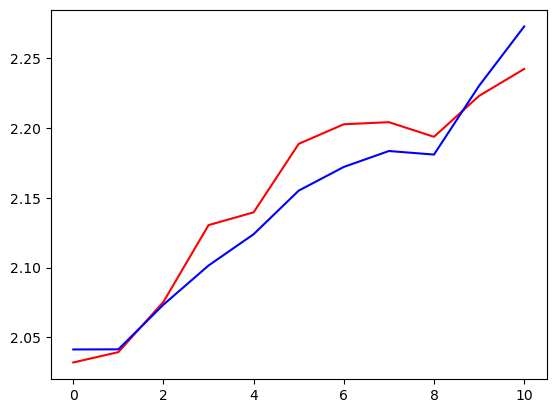

In [18]:
plt.plot(df_error["WITH extreme"].values, c="r", label="Trained with extreme")
plt.plot(df_error["WITHOUT extreme"].values, c="b", label="Trained without extreme")
plt.show()

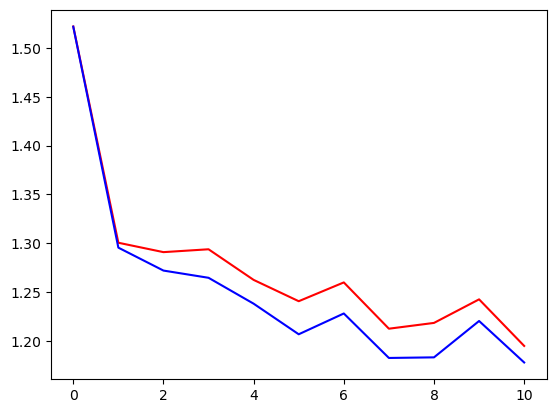

In [19]:
plt.plot(arr_in[0], c="r", label="Trained with extreme")
plt.plot(arr_in[1], c="b", label="Trained without extreme")
plt.show()

We first train the one without extreme values, tested on both test data with and without extremes. 

In [20]:
all_data_extended = all_data.copy(deep=True)

In [21]:
all_data_extended_train=all_data_extended[all_data_extended["Date"]<"2024-01-01"].dropna()

In [22]:
# all_data_extended_de=drop_extreme.drop_by_sort(df_in=all_data_extended.dropna(),fl_low=0.001,fl_high=0.999)
all_data_extended_train_de=drop_extreme.drop_by_sort(df_in=all_data_extended_train,fl_low=0.001,fl_high=0.999)
all_data_extended_test=all_data_extended[all_data_extended["Date"]>="2024-01-01"].dropna()

In [23]:
all_data_extended_test_de=drop_extreme.drop_by_sort(df_in=all_data_extended_test,fl_low=0.01,fl_high=0.99)

In [24]:
X_train=all_data_extended_train.iloc[:,2:]
y_train=all_data_extended_train.iloc[:,1]
X_de_train=all_data_extended_train_de.iloc[:,2:]
y_de_train=all_data_extended_train_de.iloc[:,1]
X_test=all_data_extended_test.iloc[:,2:]
y_test=all_data_extended_test.iloc[:,1]

In [25]:
X_de_test=all_data_extended_test_de.iloc[:,2:]
y_de_test=all_data_extended_test_de.iloc[:,1]

In [26]:
spineline_pipe = Pipeline([
    ("std", StandardScaler()),               # 1) Standardize features
    ("spline", SplineTransformer(n_knots=2, degree=1)),
    ("regressor", LinearRegression())        # 2) Fit a regression model
])

In [27]:
spineline_pipe.fit(X=X_de_train,y=y_de_train)

Pipeline(steps=[('std', StandardScaler()),
                ('spline', SplineTransformer(degree=1, n_knots=2)),
                ('regressor', LinearRegression())])

First, test on the test set with extreme values. 

In [29]:
pred_extreme=spineline_pipe.predict(X=X_test)

In [30]:
mse_extreme=mean_squared_error(y_pred=pred_extreme,y_true=y_test)

Graph for trained without extreme, tested with extreme. 

In [31]:
mse_extreme

1.4930118250264264

<function matplotlib.pyplot.show(close=None, block=None)>

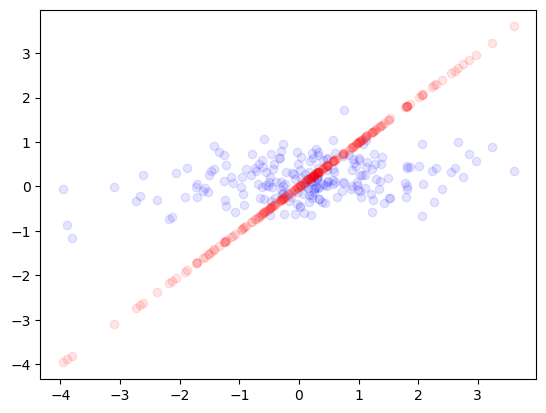

In [32]:
plt.scatter(x=y_test,y=pred_extreme,c="b",alpha=0.1,label="pred")
plt.scatter(x=y_test,y=y_test,c="r",alpha=0.1,label="true")
plt.show

Then, test on the test set without extreme values. 

In [33]:
pred_noextreme=spineline_pipe.predict(X=X_de_test)

In [34]:
mse_noextreme=mean_squared_error(y_pred=pred_noextreme,y_true=y_de_test)

Graph for trained without extreme, tested without extreme. 

In [35]:
mse_noextreme

1.3473170335866287

<function matplotlib.pyplot.show(close=None, block=None)>

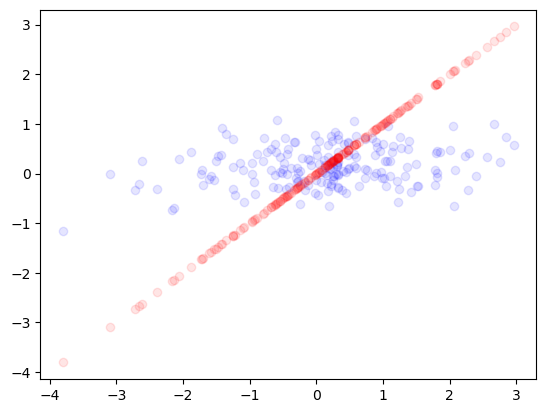

In [36]:
plt.scatter(x=y_de_test,y=pred_noextreme,c="b",alpha=0.1,label="pred")
plt.scatter(x=y_de_test,y=y_de_test,c="r",alpha=0.1,label="true")
plt.show

In [37]:
fo_feat=[[0],[1],[5],[3],[4],[2,7],[2],[1,2],[15],[2,11],[0,6],[13],[17],[0,5],[1,5]]
feat_cols=X_train.columns

print("The focused features, in order of importance are:"+"\n")
for lst_feats in fo_feat: 
    for ind in lst_feats: 
        print(feat_cols[ind])
    print("----------------------------------"+"\n")

The focused features, in order of importance are:

cop_daily_pro_change
----------------------------------

gold_daily_pro_change
----------------------------------

crude_oil_daily_pro_change
----------------------------------

pal_daily_pro_change
----------------------------------

plat_daily_pro_change
----------------------------------

silv_daily_pro_change
ppi314_monthly_pro_change
----------------------------------

silv_daily_pro_change
----------------------------------

gold_daily_pro_change
silv_daily_pro_change
----------------------------------

ppi517_monthly_pro_change
----------------------------------

silv_daily_pro_change
ppi335_monthly_pro_change
----------------------------------

cop_daily_pro_change
fed_dff_daily
----------------------------------

ppi339_monthly_pro_change
----------------------------------

ppi5182_monthly_pro_change
----------------------------------

cop_daily_pro_change
crude_oil_daily_pro_change
----------------------------------

gold_dai

Features focused, in order of importance, are 'cop_daily_pro_change', 'gold_daily_pro_change', 'crude_oil_daily_pro_change', 'pal_daily_pro_change', 'plat_daily_pro_change', 

In [38]:
all_data_train=all_data[all_data_extended["Date"]<"2024-01-01"]

In [39]:
all_data_test=all_data[all_data_extended["Date"]>="2024-01-01"]

In [40]:
all_data_test_de=drop_extreme.drop_by_sort(df_in=all_data_test,fl_low=0.01,fl_high=0.99)

In [41]:
X_train=all_data_train.iloc[:,2:]
y_train=all_data_train.iloc[:,1]
X_test=all_data_test.iloc[:,2:]
y_test=all_data_test.iloc[:,1]
X_de_test=all_data_test_de.iloc[:,2:]
y_de_test=all_data_test_de.iloc[:,1]

In [42]:
spineline_pipe = Pipeline([
    ("std", StandardScaler()),                  # standardize features
    ("spline", SplineTransformer(n_knots=2, degree=1)),
    ("regressor", LinearRegression())           # final estimator
])

In [43]:
spineline_pipe.fit(X=X_train,y=y_train)

Pipeline(steps=[('std', StandardScaler()),
                ('spline', SplineTransformer(degree=1, n_knots=2)),
                ('regressor', LinearRegression())])

In [44]:
pred_extreme=spineline_pipe.predict(X=X_test)

In [45]:
pred_noextreme=spineline_pipe.predict(X_de_test)

In [46]:
mse_extreme=mean_squared_error(y_pred=pred_extreme,y_true=y_test)

In [47]:
mse_noextreme=mean_squared_error(y_pred=pred_noextreme,y_true=y_de_test)

Graph for trained with extreme and tested with extreme. 

In [48]:
mse_extreme

1.5124739248435195

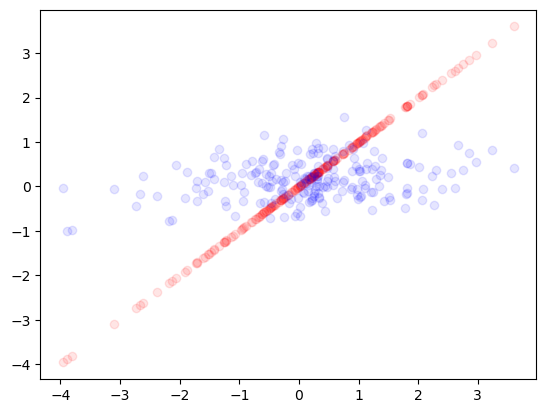

In [49]:
plt.scatter(x=y_test,y=y_test,c="r",alpha=0.1,label="true")
plt.scatter(x=y_test,y=pred_extreme,c="b",alpha=0.1,label="pred")
plt.show()

Graph for trained with extreme and tested with no extreme. 

In [50]:
mse_noextreme

1.3591363272625205

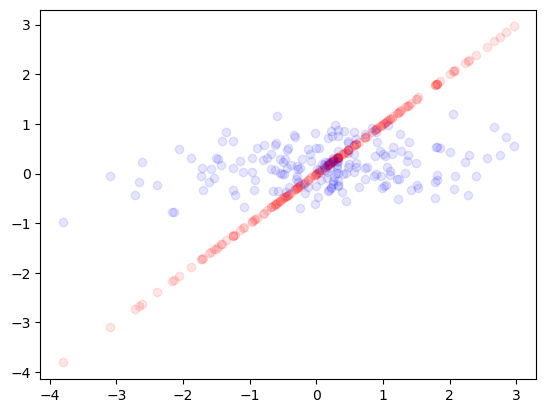

In [51]:
plt.scatter(x=y_de_test,y=y_de_test,c="r",alpha=0.1,label="true")
plt.scatter(x=y_de_test,y=pred_noextreme,c="b",alpha=0.1,label="pred")
plt.show()

In [52]:
fo_feat=[[0],[1],[5],[4],[3],[1,14],[1,2],[2],[2,11],[17],[13],[0,4],[5,12],[0,5],[2,3]]
feat_cols=X_train.columns

print("The focused features, in order of importance are:"+"\n")
for lst_feats in fo_feat: 
    for ind in lst_feats: 
        print(feat_cols[ind])
    print("----------------------------------"+"\n")

The focused features, in order of importance are:

cop_daily_pro_change
----------------------------------

gold_daily_pro_change
----------------------------------

crude_oil_daily_pro_change
----------------------------------

plat_daily_pro_change
----------------------------------

pal_daily_pro_change
----------------------------------

gold_daily_pro_change
ppi516_monthly_pro_change
----------------------------------

gold_daily_pro_change
silv_daily_pro_change
----------------------------------

silv_daily_pro_change
----------------------------------

silv_daily_pro_change
ppi335_monthly_pro_change
----------------------------------

ppi5182_monthly_pro_change
----------------------------------

ppi339_monthly_pro_change
----------------------------------

cop_daily_pro_change
plat_daily_pro_change
----------------------------------

crude_oil_daily_pro_change
ppi336_monthly_pro_change
----------------------------------

cop_daily_pro_change
crude_oil_daily_pro_change
---------

It seems more sifting does cause worse effect on whole test set, but it also seems to reduce error in the test set with no extreme values, let's try that out as well. 

In [53]:
all_data_extended = all_data.copy(deep=True)
for int_extend in range(11): 
    if int_extend != 0: 
        for col in lst_cols_shift: 
            all_data_extended=data_shifting.shifter(df_in=all_data_extended,str_col=col,int_shift=int_extend)
all_data_extended_train=all_data_extended[all_data_extended["Date"]<"2024-01-01"].dropna()
all_data_extended_train_de=drop_extreme.drop_by_sort(df_in=all_data_extended_train,fl_low=0.001,fl_high=0.999)
all_data_extended_test=all_data_extended[all_data_extended["Date"]>="2024-01-01"].dropna()
all_data_extended_test_de=drop_extreme.drop_by_sort(df_in=all_data_extended_test,fl_low=0.01,fl_high=0.99)
X_train=all_data_extended_train.iloc[:,2:]
y_train=all_data_extended_train.iloc[:,1]
X_de_train=all_data_extended_train_de.iloc[:,2:]
y_de_train=all_data_extended_train_de.iloc[:,1]
X_test=all_data_extended_test.iloc[:,2:]
y_test=all_data_extended_test.iloc[:,1]
X_de_test=all_data_extended_test_de.iloc[:,2:]
y_de_test=all_data_extended_test_de.iloc[:,1]

First train without extreme values. 

In [54]:
spineline_pipe = Pipeline([
    ("std", StandardScaler()),                  # standardize features
    ("spline", SplineTransformer(n_knots=2, degree=1)),
    ("regressor", LinearRegression())           # final estimator
])
spineline_pipe.fit(X=X_de_train,y=y_de_train)
pred_extreme=spineline_pipe.predict(X=X_test)
mse_extreme=mean_squared_error(y_pred=pred_extreme,y_true=y_test)
pred_noextreme=spineline_pipe.predict(X=X_de_test)
mse_noextreme=mean_squared_error(y_pred=pred_noextreme,y_true=y_de_test)

Test on test set with extreme value: 

In [55]:
mse_extreme

1.6172225951819807

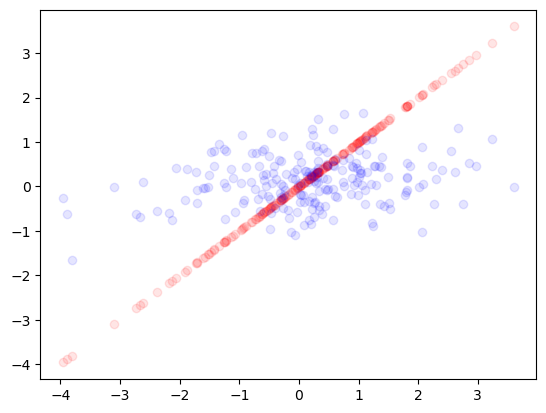

In [56]:
plt.scatter(x=y_test,y=y_test,c="r",alpha=0.1,label="true")
plt.scatter(x=y_test,y=pred_extreme,c="b",alpha=0.1,label="pred")
plt.show()

Test on test set without extreme value: 

In [57]:
mse_noextreme

1.4388030170369208

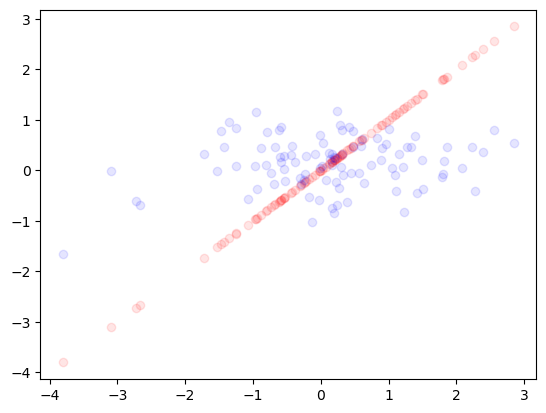

In [58]:
plt.scatter(x=y_de_test,y=y_de_test,c="r",alpha=0.1,label="true")
plt.scatter(x=y_de_test,y=pred_noextreme,c="b",alpha=0.1,label="pred")
plt.show()

In [59]:
fo_feat=[[0],[3],[5],[1],[4],[52],[25],[36,84],[1,14],[19,55],[72],[18,71],[25,45],[10,52],[39,52]]
feat_cols=X_train.columns

print("The focused features, in order of importance are:"+"\n")
for lst_feats in fo_feat: 
    for ind in lst_feats: 
        print(feat_cols[ind])
    print("----------------------------------"+"\n")

The focused features, in order of importance are:

cop_daily_pro_change
----------------------------------

pal_daily_pro_change
----------------------------------

crude_oil_daily_pro_change
----------------------------------

gold_daily_pro_change
----------------------------------

plat_daily_pro_change
----------------------------------

crude_oil_daily_pro_change_shifted_by_5
----------------------------------

tech_index_daily_pro_change_shifted_by_2
----------------------------------

pal_daily_pro_change_shifted_by_3
silv_daily_pro_change_shifted_by_10
----------------------------------

gold_daily_pro_change
ppi516_monthly_pro_change
----------------------------------

cop_daily_pro_change_shifted_by_1
gold_daily_pro_change_shifted_by_6
----------------------------------

plat_daily_pro_change_shifted_by_8
----------------------------------

tech_index_daily_pro_change_shifted_by_1
pal_daily_pro_change_shifted_by_8
----------------------------------

tech_index_daily_pro_chang

Is not really better. 

Then train with extreme values.

In [60]:
spineline_pipe = Pipeline([
    ("std", StandardScaler()),                  # standardize features
    ("spline", SplineTransformer(n_knots=2, degree=1)),
    ("regressor", LinearRegression())           # final estimator
])
spineline_pipe.fit(X=X_train,y=y_train)
pred_extreme=spineline_pipe.predict(X=X_test)
mse_extreme=mean_squared_error(y_pred=pred_extreme,y_true=y_test)
pred_noextreme=spineline_pipe.predict(X=X_de_test)
mse_noextreme=mean_squared_error(y_pred=pred_noextreme,y_true=y_de_test)

Test without extreme value: 

In [61]:
mse_extreme

1.7089639339740335

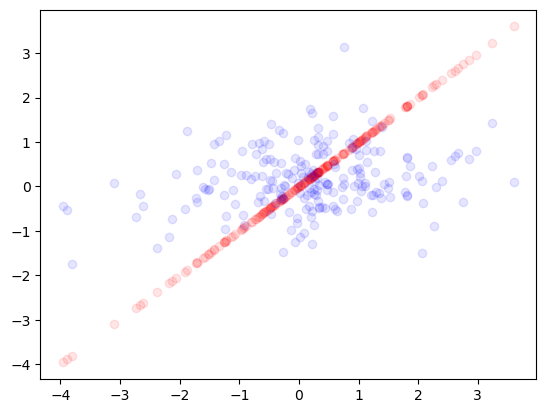

In [62]:
plt.scatter(x=y_test,y=y_test,c="r",alpha=0.1,label="true")
plt.scatter(x=y_test,y=pred_extreme,c="b",alpha=0.1,label="pred")
plt.show()

Test with extreme value: 

In [63]:
mse_noextreme

1.4414629474211929

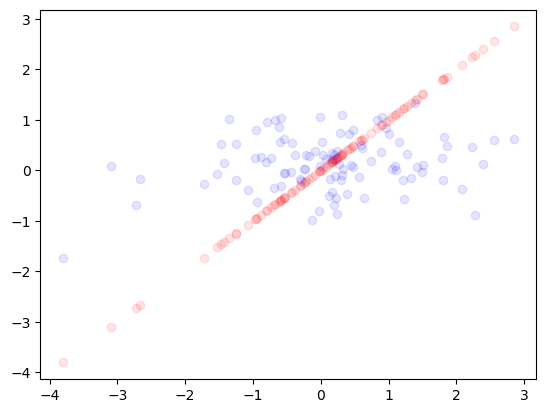

In [64]:
plt.scatter(x=y_de_test,y=y_de_test,c="r",alpha=0.1,label="true")
plt.scatter(x=y_de_test,y=pred_noextreme,c="b",alpha=0.1,label="pred")
plt.show()

In [65]:
fo_feat=[[0],[5],[1],[3],[4],[18],[53],[52],[67],[60],[25],[30],[86],[0,53],[74]]
feat_cols=X_train.columns

print("The focused features, in order of importance are:"+"\n")
for lst_feats in fo_feat: 
    for ind in lst_feats: 
        print(feat_cols[ind])
    print("----------------------------------"+"\n")

The focused features, in order of importance are:

cop_daily_pro_change
----------------------------------

crude_oil_daily_pro_change
----------------------------------

gold_daily_pro_change
----------------------------------

pal_daily_pro_change
----------------------------------

plat_daily_pro_change
----------------------------------

tech_index_daily_pro_change_shifted_by_1
----------------------------------

tech_index_daily_pro_change_shifted_by_6
----------------------------------

crude_oil_daily_pro_change_shifted_by_5
----------------------------------

tech_index_daily_pro_change_shifted_by_8
----------------------------------

tech_index_daily_pro_change_shifted_by_7
----------------------------------

tech_index_daily_pro_change_shifted_by_2
----------------------------------

plat_daily_pro_change_shifted_by_2
----------------------------------

plat_daily_pro_change_shifted_by_10
----------------------------------

cop_daily_pro_change
tech_index_daily_pro_change_shi

Seems to have a "better slope". 